In [4]:
import scipy.io as scio
import numpy as np
import pandas as pd

from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from sklearn.metrics import *
from keras.models import Sequential,Model
from keras.layers import *

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [6]:
pwd

'/Users/p.scott'

In [8]:
PATH ="./Desktop/lz/"

In [9]:
data = scio.loadmat(PATH+'RHYTHMS.mat')

In [10]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SR', 'VT', 'VF'])

In [11]:
#将。mat文件中的三物件数据分别存储到三个不同的变量中
SR_data = data['SR']
VT_data = data['VT']
VF_data = data['VF']

In [12]:
type(SR_data)
type(VT_data)
type(VF_data)

numpy.ndarray

numpy.ndarray

numpy.ndarray

In [13]:
#数据维度
SR_data.shape
VT_data.shape
VF_data.shape

(1, 488)

(1, 46)

(1, 60)

In [14]:
SR_data[0][0]
VT_data[0][0]
VF_data[0][0]

array([[ 29.42975058,  27.36808684],
       [ 29.37169797,  34.31769491],
       [ 28.99323827,  28.28577198],
       ...,
       [118.21177505, 169.03518084],
       [290.78267347, 118.58490454],
       [122.88673417, -54.74714758]])

array([[-21.67671125,   5.42781089],
       [-13.26543965,  11.74437439],
       [-10.57220052,  11.94258601],
       ...,
       [-30.51402258,   3.98168972],
       [-24.54658296,   9.72201618],
       [-25.24517226,   6.82009343]])

array([[-114.81119099,  -30.38372231],
       [-101.6909332 ,  -30.72394659],
       [ -74.3865354 ,  -25.8404295 ],
       ...,
       [  26.82129656,    4.93117365],
       [  24.09317195,    6.66421298],
       [  12.82659701,    9.36575575]])

In [15]:
len(SR_data[0])

488

In [16]:
SR_data[0][0][:,0]

array([ 29.42975058,  29.37169797,  28.99323827, ..., 118.21177505,
       290.78267347, 122.88673417])

In [17]:
def f(src):
    res = []
    for i in range(len(src[0])):
        res.append(src[0][i][:,0])
    return res

In [18]:
SR_test = []
VT_test = []
VF_test = []

In [19]:
#舍去频谱图当中的第一列（B列）
SR_test = f(SR_data)
VT_test = f(VT_data)
VF_test = f(VF_data)

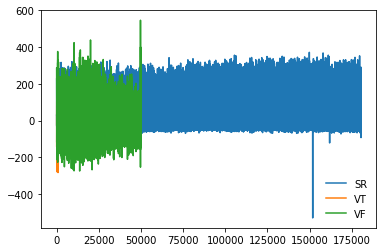

In [20]:
#初次尝试作图，发现数据长度不一样带来的数据高度密集
fig,ax = plt.subplots()
ax.plot(SR_test[0],label = 'SR')
ax.plot(VT_test[0],label = 'VT')
ax.plot(VF_test[0],label = 'VF')
ax.legend(loc='lower right', frameon=False)

<Figure size 1440x720 with 0 Axes>

(0, 800)

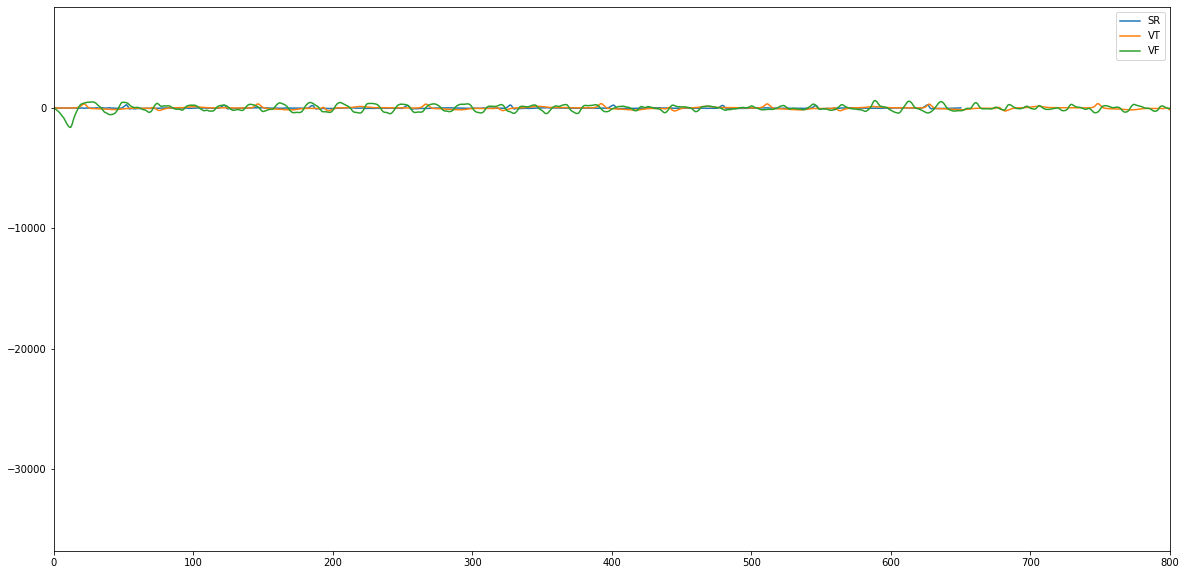

In [23]:
#可以大致看出每个种类的频谱具有不一样的特征
plt.figure(figsize=(20,10))
plt.xlim(0,800)
plt.plot(SR_test[100],label='SR')
plt.plot(VT_test[1],label='VT')
plt.plot(VF_test[20],label='VF')
plt.legend()

<Figure size 1440x720 with 0 Axes>

(0, 800)

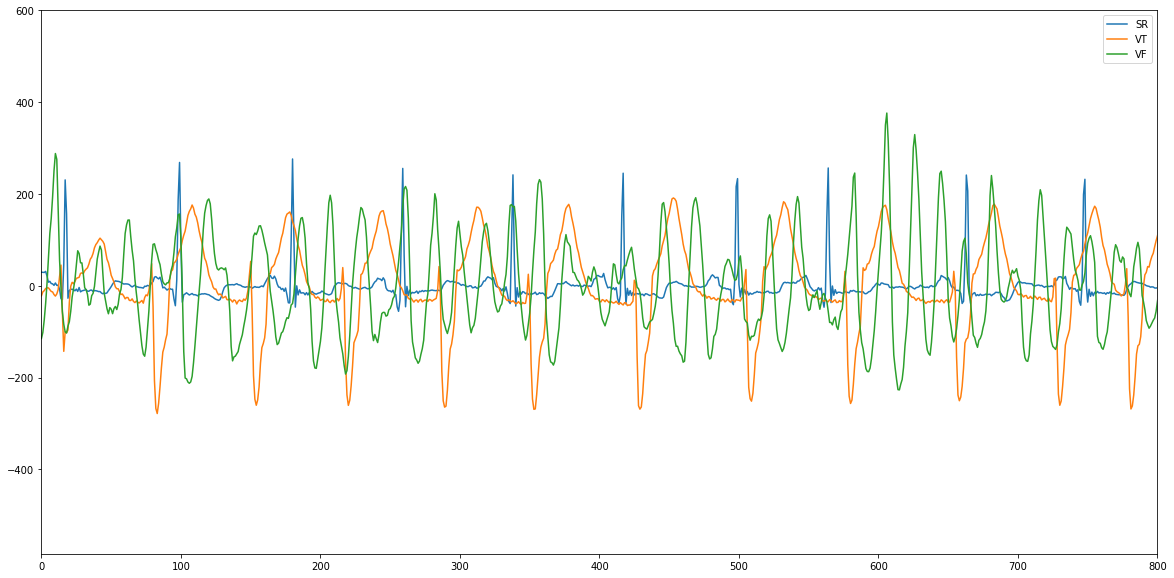

In [24]:
plt.figure(figsize=(20,10))
plt.xlim(0,800)
plt.plot(SR_test[0],label='SR')
plt.plot(VT_test[0],label='VT')
plt.plot(VF_test[0],label='VF')
plt.legend()

In [25]:
def show_len(data):
    res = []
    for i in range(len(data)):
        res.append(len(data[i]))
    return res

In [26]:
#长度显示：每个数据长度都不一样，所以不能从数据长度来判断物件种类
SR_len = show_len(SR_test)
VT_len = show_len(VT_test)
VF_len = show_len(VF_test)

In [27]:
SR = pd.DataFrame({'Signal':SR_test,'Classification':'SR'})
VT = pd.DataFrame({'Signal':VT_test,'Classification':'VT'})
VF = pd.DataFrame({'Signal':VF_test,'Classification':'VF'})

In [28]:
VF

,Signal,Classification
0,"[-114.81119098866763, -101.69093320453392, -74...",VF
1,"[12.826597008997549, 13.355284511573393, 7.215...",VF
2,"[-80.0124272629081, -86.78797729796932, -104.7...",VF
3,"[29.647250429222073, 32.51254305138988, 26.019...",VF
4,"[23.218166373620686, 18.632331215883315, 14.05...",VF
5,"[24.493514461854463, 16.002491240993066, 8.562...",VF
6,"[-12.123384328256547, 16.864564762581125, 31.2...",VF
7,"[-20.93338666082853, -28.8053184611498, -26.09...",VF
8,"[-37.22138524474476, -39.08668903217398, -41.5...",VF
9,"[6.361820509712498, 8.160367796777022, 10.7622...",VF


In [29]:
all_data = pd.concat([SR,VT,VF])

In [30]:
all_data

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",SR
1,"[-8.887452260151282, -6.318858287707609, -4.24...",SR
2,"[12.790383577957149, 7.893029776621113, 8.0538...",SR
3,"[-3.836657273045951, -5.199758952374646, -4.43...",SR
4,"[-25.87328222407625, -21.18422677138712, -16.9...",SR
5,"[69.88652647369534, 101.4635148870283, 65.0005...",SR
6,"[72.21190031860417, 59.53650854336529, 55.1409...",SR
7,"[72.78028273100328, 69.30635382594558, 67.3578...",SR
8,"[4.862226746248392, 1.823196617050331, 6.43569...",SR
9,"[60.828292819390015, 62.79440962378961, 67.711...",SR


In [31]:
all_data = all_data.reset_index(drop=True)

In [32]:
all_data

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",SR
1,"[-8.887452260151282, -6.318858287707609, -4.24...",SR
2,"[12.790383577957149, 7.893029776621113, 8.0538...",SR
3,"[-3.836657273045951, -5.199758952374646, -4.43...",SR
4,"[-25.87328222407625, -21.18422677138712, -16.9...",SR
5,"[69.88652647369534, 101.4635148870283, 65.0005...",SR
6,"[72.21190031860417, 59.53650854336529, 55.1409...",SR
7,"[72.78028273100328, 69.30635382594558, 67.3578...",SR
8,"[4.862226746248392, 1.823196617050331, 6.43569...",SR
9,"[60.828292819390015, 62.79440962378961, 67.711...",SR


In [33]:
from sklearn import preprocessing

In [34]:
le = preprocessing.LabelEncoder()

In [35]:
data = all_data.copy()

In [36]:
data['Classification'] = le.fit_transform(data['Classification'])

In [37]:
data.head()

,Signal,Classification
0,"[29.42975058166, 29.37169797310235, 28.9932382...",0
1,"[-8.887452260151282, -6.318858287707609, -4.24...",0
2,"[12.790383577957149, 7.893029776621113, 8.0538...",0
3,"[-3.836657273045951, -5.199758952374646, -4.43...",0
4,"[-25.87328222407625, -21.18422677138712, -16.9...",0


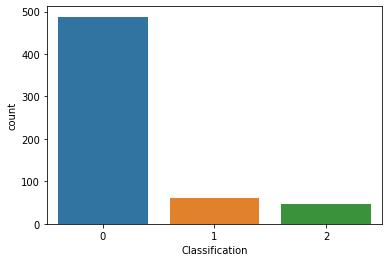

In [39]:
sns.countplot(x='Classification',data = data)

In [40]:
data['rnd'] = np.random.rand(len(data))
data = data.sort_values(by='rnd').drop('rnd',axis=1)

In [41]:
data.head()

,Signal,Classification
311,"[-24.58246175951142, -23.463778665222446, -28....",0
251,"[-24.735072448238746, -29.942883348304658, -24...",0
110,"[19.563521661461408, 19.47279158828802, 14.043...",0
1,"[-8.887452260151282, -6.318858287707609, -4.24...",0
115,"[8.547323102251138, -18.4082237096421, -18.536...",0


In [42]:
l = 100000
for i in data['Signal']:
    if len(i)<l:
        l = len(i)

In [43]:
l

501

In [44]:
data.to_csv(PATH+'train.csv')

In [45]:
data.head()

,Signal,Classification
311,"[-24.58246175951142, -23.463778665222446, -28....",0
251,"[-24.735072448238746, -29.942883348304658, -24...",0
110,"[19.563521661461408, 19.47279158828802, 14.043...",0
1,"[-8.887452260151282, -6.318858287707609, -4.24...",0
115,"[8.547323102251138, -18.4082237096421, -18.536...",0


In [49]:
li = [3,4,5,6,7]
max(li)
min(li)

7

3

In [56]:
def regular(li):
    max_li = max(li)
    min_li = min(li)
    length = max_li - min_li
    for ele in range(len(li)):
        li[ele] = (li[ele]-min_li)/length
    return li   

In [63]:
data.Signal = data.Signal.map(regular)

In [64]:
data.head()

,Signal,Classification
311,"[0.3799707594382002, 0.38187862703805864, 0.37...",0
251,"[0.1558212096040829, 0.1397775864509801, 0.156...",0
110,"[0.5607927484662847, 0.5606883902097085, 0.554...",0
1,"[0.4909542186047959, 0.493689271221415, 0.4959...",0
115,"[0.5936254087688092, 0.5544081532339095, 0.554...",0


In [65]:
X = pad_sequences(data['Signal'], maxlen=500, padding='post')


In [66]:
X.shape

(594, 500)

In [67]:
y = data['Classification'].values

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [70]:
import tensorflow as tf

In [82]:
model3 = Sequential()
model3.add(Dense(16,input_shape=(500,),activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(4,activation='relu'))
model3.add(Dense(3,activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                8016      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 15        
Total params: 8,099
Trainable params: 8,099
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
model3.fit(x_train,y_train,epochs=30)

Epoch 1/30
564/564 [==============================] - 0s 68us/step - loss: 0.9258 - acc: 0.8209
Epoch 2/30
564/564 [==============================] - 0s 62us/step - loss: 0.8585 - acc: 0.8209
Epoch 3/30
564/564 [==============================] - 0s 56us/step - loss: 0.7825 - acc: 0.8209
Epoch 4/30
564/564 [==============================] - 0s 55us/step - loss: 0.7157 - acc: 0.8209
Epoch 5/30
564/564 [==============================] - 0s 54us/step - loss: 0.6656 - acc: 0.8209
Epoch 6/30
564/564 [==============================] - 0s 56us/step - loss: 0.6318 - acc: 0.8209
Epoch 7/30
564/564 [==============================] - 0s 53us/step - loss: 0.6112 - acc: 0.8209
Epoch 8/30
564/564 [==============================] - 0s 62us/step - loss: 0.6010 - acc: 0.8209
Epoch 9/30
564/564 [==============================] - 0s 70us/step - loss: 0.6059 - acc: 0.8209
Epoch 10/30
564/564 [==============================] - 0s 55us/step - loss: 0.5870 - acc: 0.8209
Epoch 11/30
564/564 [==================

In [85]:
predictions = model3.predict(x_test)

In [90]:
type(predictions[0])

numpy.ndarray

In [93]:
def output_res(predictions):
    res = []
    for i in range(len(predictions)):
        tmp = np.argmax(predictions[i])
        if tmp == 0:
            res.append('SR')
        elif tmp == 1:
            res.append('VT')
        elif tmp == 2:
            res.append('VF')
        else:
            res.append('Unknown')
    return res

In [94]:
res = output_res(predictions)

In [95]:
res

['SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR',
 'SR']